# Current segmentation procedure

**Note:** we recommend restarting the kernel when running each new example.

## Synthetic examples

In [ ]:
# If running in Colab, get ACT and neuron

# TODO: remove release_candidate when merged with main

# !git clone https://github.com/V-Marco/ACT.git
# %cd ACT
# !git switch release_candidate

# !pip install neuron

fatal: destination path 'ACT' already exists and is not an empty directory.
/content/ACT
Already on 'release_candidate'
Your branch is up to date with 'origin/release_candidate'.


In [18]:
from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.segregation import ACTSegregator
from act.types import SimulationParameters, ConstantCurrentInjection

In [19]:
import matplotlib.pyplot as plt
import numpy as np

### Spiker

Classic Hodgkin-Huxely-based Spiker model.

Parameters (both original and segregated):
- Cm = 1
- gnabar = .12 (S/cm2)
- gkbar = .036 (S/cm2)
- gl = .0003 (S/cm2)
- el = -54.3 (mV)

Modules:
- Spiking: [gnabar, gkbar]

**Step 1.** The spiker model has only 2 modules:
- Passive (includes only the leak channel, so no action needed).
- Spiking (Na and Kdr channels).

**Steps 2 and 3.** Transfer the activation functions from the modfiles and plot them. We additionally plot E-leak for reference.

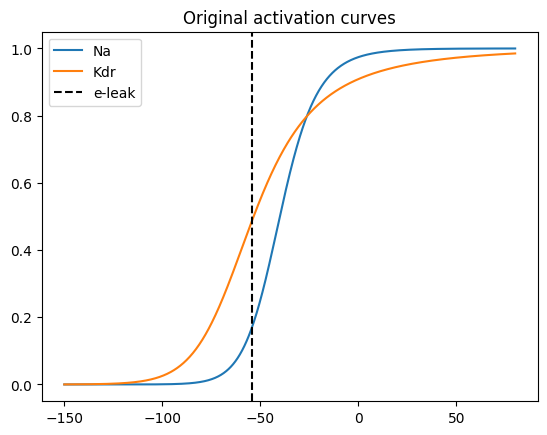

In [2]:
# From ACT/data/Spiker/orig/modfiles/hh.mod
def vtrap(x,y):
    if np.any(np.abs(x/y) < 1e-6):
        vtrap = y * (1 - x/y/2)
    else:
        vtrap = x / (np.exp(x/y) - 1)
    return vtrap

def Na(v):
    aNa = 0.1 * vtrap(-(v + 40), 10)
    bNa =  4 * np.exp(-(v + 65) / 18)
    return aNa / (aNa + bNa)

def Kdr(v):
    aK = 0.01 * vtrap(-(v + 55),10)
    bK = 0.125 * np.exp(-(v + 65) / 80)
    return aK / (aK + bK)

v = np.linspace(-150, 80, 1000)

plt.plot(v, Na(v), label = 'Na')
plt.plot(v, Kdr(v), label = 'Kdr')
plt.title("Original activation curves")
plt.axvline(-54.3, color = 'black', ls = '--', label = "e-leak")
plt.legend()

In [36]:
color_map = {
    "Na": "tab:blue",
    "Na3": "tab:blue",
    "Kdr": "tab:orange",
    "KA": "tab:green",
    "CaT": "tab:red",
    "CaS": "tab:purple",
    "H": "tab:brown",
    "Nap": "tab:pink",
    "KM": "tab:gray"
}

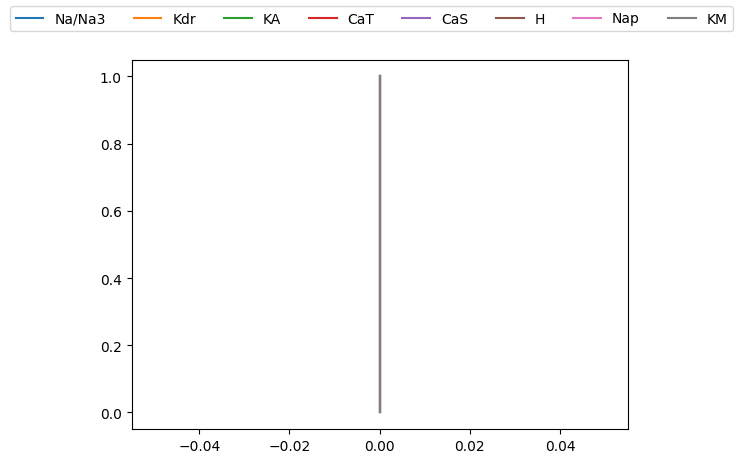

In [62]:
fig, ax = plt.subplots(1, 1)
for key, value in color_map.items():
    if key == "Na": continue
    ax.plot([0, 0], [0, 1], color = value, label = key)

keys = list(color_map.keys())[1:]
keys[0] = "Na/Na3"
fig.legend(ax.get_legend_handles_labels()[0], keys, loc = "upper center", ncol = 8)
fig.savefig("legend.png", format = 'png', bbox_inches = "tight", dpi = 500)

The segregation procedure is implemented in `ACTSegregator`. It outputs segregated activation functions together with text to update the modfiles (the text includes cutoff and extrapolation voltages and line parameters).

In [3]:
segregator = ACTSegregator()
seg_Na, seg_Kdr = segregator.segregate(v = v, activation_curves = [Na(v), Kdr(v)], cutoff_v = -54.3, extrapolate_dv = 2)

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -52.3) {
        replace_with_var_name = 0.102 * v + 5.512
        }
        if (v < -54.3) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -52.3) {
        replace_with_var_name = 0.258 * v + 14.0
        }
        if (v < -54.3) {
        replace_with_var_name = 0
        }
        


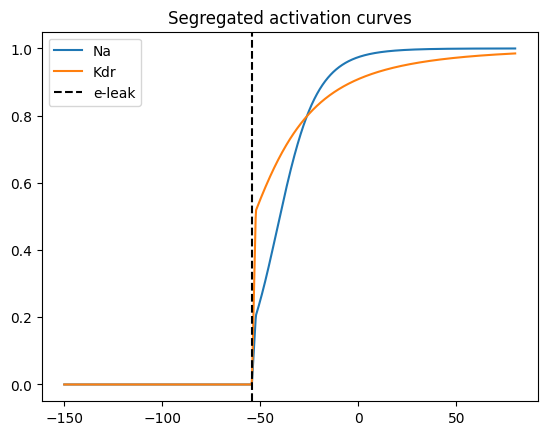

In [4]:
plt.plot(v, seg_Na, label = 'Na')
plt.plot(v, seg_Kdr, label = 'Kdr')
plt.title("Segregated activation curves")
plt.axvline(-54.3, color = 'black', ls = '--', label = "e-leak")
plt.legend()

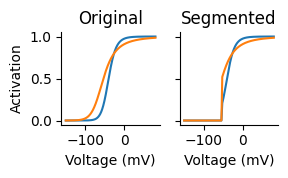

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (2.8, 1.2), sharey = True)

ca = ax[0]
ca.plot(v, Na(v), label = 'Na')
ca.plot(v, Kdr(v), label = 'Kdr')
ca.set_ylabel("Activation")
ca.set_title("Original")

ca = ax[1]
ca.plot(v, seg_Na, label = 'Na')
ca.plot(v, seg_Kdr, label = 'Kdr')
ca.set_title("Segmented")

for ca in ax.flatten():
    ca.spines[['right', 'top']].set_visible(False)
    ca.set_xlabel("Voltage (mV)")

plt.subplots_adjust(wspace = 0.2)
fig.savefig("spiker_seg.png", format = 'png', bbox_inches = "tight", dpi = 500)

### BursterCa

Ca-based burster.

Parameters:
- eleak = -50
- gbar_leak = 4e-05
- gbar_na = 0.13
- gbar_kdr = 0.1
- gbar_cas = 0.01
- gbar_ka = 0.17
- gbar_cat = 0.005

Modules:
- Bursting: [gbar_cas, gbar_ka, gbar_cat]
- Spiking: [gnabar, gkbar]

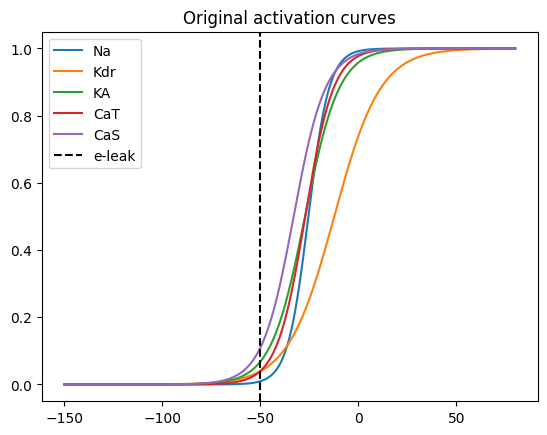

In [47]:
def Na(v):
    return 1.0/(1.0+ (np.exp((v+25.5)/(-5.29))))

def Kdr(v):
    return 1.0/(1.0 + (np.exp((v+12.3)/(-11.8))))

def KA(v):
    return 1.0/(1.0+(np.exp((v+27.2)/(-8.7))))

def CaT(v):
    return 1.0/(1.0+ (np.exp((v+27.1)/(-7.2))))

def CaS(v):
    return (1.0)/(1+ (np.exp((v+33.0)/(-8.1))))

v = np.linspace(-150, 80, 1000)

for func, func_name in zip([Na, Kdr, KA, CaT, CaS], ["Na", "Kdr", "KA", "CaT", "CaS"]):
    plt.plot(v, func(v), label = func_name)

plt.title("Original activation curves")
plt.axvline(-50, color = 'black', ls = '--', label = "e-leak")
plt.legend()

In [48]:
segregator = ACTSegregator()

segregated_bursting = segregator.segregate(v = v, activation_curves = [KA(v), CaT(v), CaS(v)], cutoff_v = -50)

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -48) {
        replace_with_var_name = 0.042 * v + 2.095
        }
        if (v < -50) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -48) {
        replace_with_var_name = 0.026 * v + 1.299
        }
        if (v < -50) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 2:

        :Segregation
        if (v < -48) {
        replace_with_var_name = 0.068 * v + 3.388
        }
        if (v < -50) {
        replace_with_var_name = 0
        }
        


In [49]:
segregated_spiking = segregator.segregate(v = v, activation_curves = [Na(v), Kdr(v)], cutoff_v = -40)

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -38) {
        replace_with_var_name = 0.042 * v + 1.689
        }
        if (v < -40) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -38) {
        replace_with_var_name = 0.05 * v + 2.018
        }
        if (v < -40) {
        replace_with_var_name = 0
        }
        


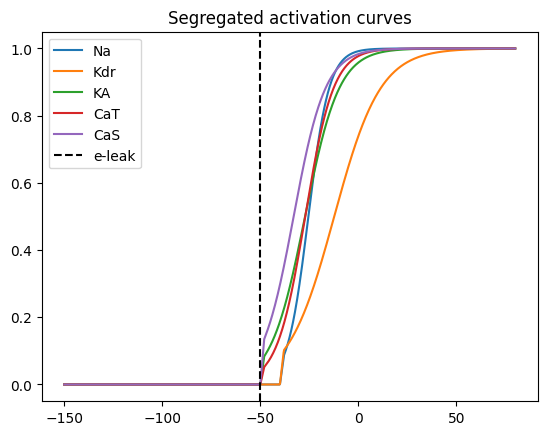

In [50]:
for ac, ac_name in zip(segregated_spiking, ["Na", "Kdr"]):
    plt.plot(v, ac, label = ac_name)
for ac, ac_name in zip(segregated_bursting, ["KA", "CaT", "CaS"]):
    plt.plot(v, ac, label = ac_name)

plt.title("Segregated activation curves")
plt.axvline(-50, color = 'black', ls = '--', label = "e-leak")
plt.legend()

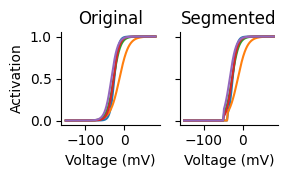

In [51]:
fig, ax = plt.subplots(1, 2, figsize = (2.8, 1.2), sharey = True)

ca = ax[0]
for func, func_name in zip([Na, Kdr, KA, CaT, CaS], ["Na", "Kdr", "KA", "CaT", "CaS"]):
    ca.plot(v, func(v), label = func_name, color = color_map[func_name])
ca.set_ylabel("Activation")
ca.set_title("Original")

ca = ax[1]
for ac, ac_name in zip(segregated_spiking, ["Na", "Kdr"]):
    ca.plot(v, ac, label = ac_name, color = color_map[ac_name])
for ac, ac_name in zip(segregated_bursting, ["KA", "CaT", "CaS"]):
    ca.plot(v, ac, label = ac_name, color = color_map[ac_name])
ca.set_title("Segmented")

for ca in ax.flatten():
    ca.spines[['right', 'top']].set_visible(False)
    ca.set_xlabel("Voltage (mV)")

plt.subplots_adjust(wspace = 0.2)
fig.savefig("burster_seg.png", format = 'png', bbox_inches = "tight", dpi = 500)

### LA-A Cell

Parameters (original):
- el_leak = -70
- glbar_leak = 3.5e-5
- ghdbar_hd=2.3e-05
- gbar_na3=0.03
- gkdrbar_kdr=0.003
- gbar_nap= 0.0003
- gmbar_im = 0.002
- gkabar_kap = 0.000843
- gcabar_cadyn = 6e-5
- gsAHPbar_sAHP = 0.009

Modules:
- Passive: [h]
- LTO: [NaP, KM]
- Spiking: [Na3, Kdr]
- Bursting: [KA, Ca]

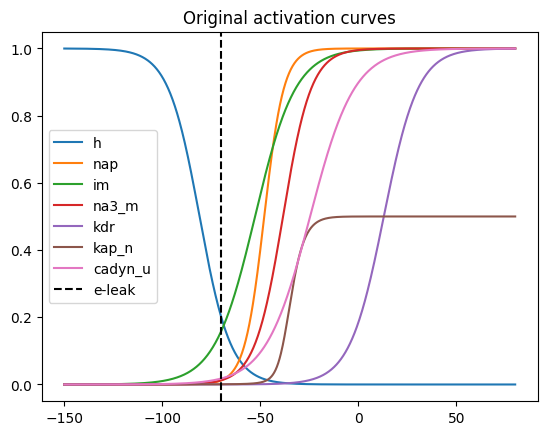

In [29]:
def vtrap(x, y):
    if np.any(np.abs(x / y) < 1e-6):
        return y * (1 - x / y / 2)
    else:
        return x / (np.exp(x / y) - 1)

#CADYN
def cadyn_u(v):
    return 1/(np.exp(-(v+24.6)/11.3)+1)

#H
def h(v):
    return 1/(1 + np.exp(-(v+81)/-8))

#IM
def im(v):
    return 1 / ( 1 + np.exp( ( - v - 52.7 ) / 10.34 ) )

#KAP

def kap_n(v):
    zeta=-2.5/(1+np.exp((v+40)/5))
    alpn = np.exp(1.e-3*zeta*(v-11)*9.648e4/(8.315*(273.16+31))) 
    return 1/(1 + alpn)

#KDR
def kdr(v):
    return 1 / ( 1 + np.exp( ( - v + 13 ) / 8.738 ) )

#NA3
def na3_m(v):
    return 1 / ( 1 + np.exp( ( - v - 38.43 ) / 7.2 ) )

#NAP
def nap(v):
    return 1 / ( 1 + np.exp( ( - v - 48 ) / 5 ) )

v = np.linspace(-150, 80, 1000)

for func, func_name in zip([h, nap, im, na3_m, kdr, kap_n, cadyn_u], ["h", "nap", "im", "na3_m", "kdr", "kap_n", "cadyn_u"]):
    plt.plot(v, func(v), label = func_name)

plt.title("Original activation curves")
plt.axvline(-70, color = 'black', ls = '--', label = "e-leak")
plt.legend()


In [30]:
segregator = ACTSegregator()

segregated_passive = segregator.segregate(v = v, activation_curves = [h(v)], cutoff_v = -70)
segregated_lto = segregator.segregate(v = v, activation_curves = [nap(v), im(v)], cutoff_v = -70)
segregated_spiking = segregator.segregate(v = v, activation_curves = [na3_m(v), kdr(v)], cutoff_v = -60)
segregated_bursting = segregator.segregate(v = v, activation_curves = [kap_n(v), cadyn_u(v)], cutoff_v = -40)

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v > -72) {
        replace_with_var_name = -0.122 * v + -8.539
        }
        if (v > -70) {
        replace_with_var_name = 0
        }
        
Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -68) {
        replace_with_var_name = 0.009 * v + 0.625
        }
        if (v < -70) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -68) {
        replace_with_var_name = 0.092 * v + 6.472
        }
        if (v < -70) {
        replace_with_var_name = 0
        }
        
Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -58) {
        replace_with_var_name = 0.03 * v + 1.824
        }
        if (v < -60) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:


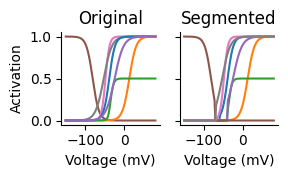

In [44]:
fig, ax = plt.subplots(1, 2, figsize = (2.8, 1.2), sharey = True)

ca = ax[0]
for func, func_name in zip([h, nap, im, na3_m, kdr, kap_n, cadyn_u], ["H", "Nap", "KM", "Na3", "Kdr", "KA", "CaS"]):
    ca.plot(v, func(v), label = func_name, color = color_map[func_name])
ca.set_ylabel("Activation")
ca.set_title("Original")

ca = ax[1]
for ac, ac_name in zip(segregated_spiking, ["Na3", "Kdr"]):
    plt.plot(v, ac, label = ac_name, color = color_map[ac_name])
for ac, ac_name in zip(segregated_bursting, ["KA", "CaS"]):
    plt.plot(v, ac, label = ac_name, color = color_map[ac_name])
for ac, ac_name in zip(segregated_passive, ["H"]):
    plt.plot(v, ac, label = ac_name, color = color_map[ac_name])
for ac, ac_name in zip(segregated_lto, ["Nap", "KM"]):
    plt.plot(v, ac, label = ac_name, color = color_map[ac_name])
ca.set_title("Segmented")

for ca in ax.flatten():
    ca.spines[['right', 'top']].set_visible(False)
    ca.set_xlabel("Voltage (mV)")

plt.subplots_adjust(wspace = 0.2)
fig.savefig("laa_seg.png", format = 'png', bbox_inches = "tight", dpi = 500)

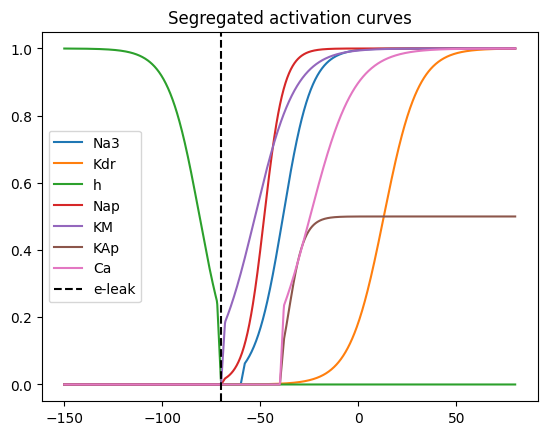

In [33]:
for ac, ac_name in zip(segregated_spiking, ["Na3", "Kdr"]):
    plt.plot(v, ac, label = ac_name)
for ac, ac_name in zip(segregated_passive, ["h"]):
    plt.plot(v, ac, label = ac_name)
for ac, ac_name in zip(segregated_lto, ["Nap", "KM"]):
    plt.plot(v, ac, label = ac_name)
for ac, ac_name in zip(segregated_bursting, ["KAp", "Ca"]):
    plt.plot(v, ac, label = ac_name)

plt.title("Segregated activation curves")
plt.axvline(-70, color = 'black', ls = '--', label = "e-leak")
plt.legend()

In [17]:
orig_cell = ACTCellModel(
    cell_name = "Cell_A",
    path_to_hoc_file = "data/LAA/orig/target_template.hoc",
    path_to_mod_files = "data/LAA/orig/modfiles/",
    passive = ["glbar_leak", "el_leak", "ghdbar_hd"],
    active_channels = ["gbar_nap", "gmbar_im", "gbar_na3", "gkdrbar_kdr", "gkabar_kap", "gcabar_cadyn"]
)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(
    orig_cell, 
    SimulationParameters(
        sim_name = "LAA_orig", 
        sim_idx = 1, 
        h_celsius = 37, 
        CI = [ConstantCurrentInjection(amp = 0.1, dur = 200, delay = 100)])
)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [18]:
seg_cell = ACTCellModel(
    cell_name = "Cell_A",
    path_to_hoc_file = "data/LAA/orig/target_template.hoc",
    path_to_mod_files = "data/LAA/seg/modfiles/",
    passive = ["glbar_leak", "el_leak", "ghdbar_hd"],
    active_channels = ["gbar_nap", "gmbar_im", "gbar_na3", "gkdrbar_kdr", "gkabar_kap", "gcabar_cadyn"]
)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(
    seg_cell, 
    SimulationParameters(
        sim_name = "LAA_seg", 
        sim_idx = 1,
        h_celsius = 37, 
        CI = [ConstantCurrentInjection(amp = 0.1, dur = 200, delay = 100)])
)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


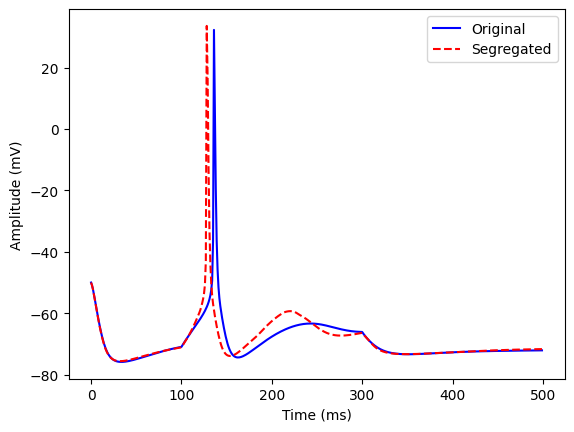

In [20]:
orig_out = np.load("output/LAA_orig/out_1.npy")
seg_out = np.load("output/LAA_seg/out_1.npy")

plt.plot(orig_out[::10, 0], label = "Original", c = 'blue')
plt.plot(seg_out[::10, 0], label = "Segregated", ls = '--', c = 'red')
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time (ms)")
plt.legend()

## Realistic examples

### SST & L5 Cells (Allen Database) – modfiles are shared

Layer 2/3 cell and L5 cell from the mouse primary visual area.

In [20]:
color_map = {
    "NaTa": "tab:blue",
    "Kdr": "tab:orange",
    "KT": "tab:green",
    "CaLVA": "tab:red",
    "CaHVA": "tab:purple",
    "H": "tab:brown",
    "Nap": "tab:pink",
    "KM": "tab:gray",
    "Kv2": "tab:olive",
    "Kv3": "tab:cyan"
}

In [21]:
def vtrap(x, y):
    if np.any(np.abs(x / y) < 1e-6):
        return y * (1 - x / y / 2)
    else:
        return x / (np.exp(x / y) - 1)

def H(v):
    mAlpha = 0.001 * 6.43 * vtrap(v + 154.9, 11.9)
    mBeta  =  0.001*193*np.exp(v/33.1)
    return mAlpha/(mAlpha + mBeta)

def NaTa(v):
    malphaF = 0.182
    mbetaF = 0.124
    mvhalf = -48
    mk = 6
    mAlpha = malphaF * vtrap(-(v - mvhalf), mk)
    mBeta = mbetaF * vtrap((v - mvhalf), mk)
    mInf = mAlpha/(mAlpha + mBeta)
    return mInf

def Nap(v):
    return 1.0/(1+np.exp((v- -52.6)/-4.6))

def Kd(v):
    return 1 - 1 / (1 + np.exp((v - (-43)) / 8))

def Kv2like(v):
    mAlpha = 0.12 * vtrap( -(v - 43), 11.0)
    mBeta = 0.02 * np.exp(-(v + 1.27) / 120)
    return mAlpha/(mAlpha + mBeta)

def Kv31(v):
    return 1/(1+np.exp(((v -(18.700 + 0))/(-9.700))))

def K_T(v): # Transient potassium
    return 1/(1 + np.exp(-(v - (-47 + 0)) / 29))

def Imv2(v):
    mAlpha = 3.3e-3*np.exp(2.5*0.04*(v - -35))
    mBeta = 3.3e-3*np.exp(-2.5*0.04*(v - -35))
    return mAlpha/(mAlpha + mBeta)

# SK is purely Ca-dependent, skipping
def CaHVA(v):
    mAlpha = 0.055 * vtrap(-27 - v, 3.8)
    mBeta  =  (0.94*np.exp((-75-v)/17))
    return mAlpha/(mAlpha + mBeta)

def CaLVA(v):
    return 1.0000/(1+ np.exp((v - -30.000)/-6))

In [ ]:
segregator = ACTSegregator()
segregated_passive = segregator.segregate(v, [H(v)], cutoff_v = -79.66)
segregated_lto = segregator.segregate(v = v, activation_curves = [Nap(v), Imv2(v), K_T(v)], cutoff_v = -79.66)
segregated_spiking = segregator.segregate(v = v, activation_curves = [NaTa(v), Kd(v)], cutoff_v = -60)
segregated_bursting = segregator.segregate(v = v, activation_curves = [CaLVA(v), CaHVA(v), Kv2like(v), Kv31(v)], cutoff_v = -40)

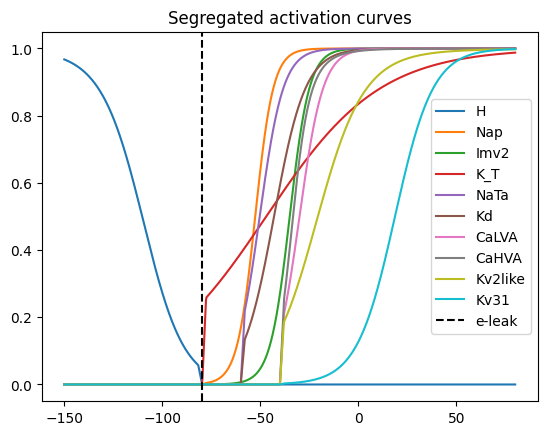

In [23]:
for ac, ac_name in zip(segregated_passive, ["H"]):
    plt.plot(v, ac, label = ac_name)

for ac, ac_name in zip(segregated_lto, ["Nap", "Imv2", "K_T"]):
    plt.plot(v, ac, label = ac_name)    

for ac, ac_name in zip(segregated_spiking, ["NaTa", "Kd"]):
    plt.plot(v, ac, label = ac_name)

for ac, ac_name in zip(segregated_bursting, ["CaLVA", "CaHVA", "Kv2like", "Kv31"]):
    plt.plot(v, ac, label = ac_name)

plt.title("Segregated activation curves")
plt.axvline(-79.66, color = 'black', ls = '--', label = "e-leak")
plt.legend()

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v > -74.9) {
        replace_with_var_name = -0.015 * v + -1.071
        }
        if (v > -72.9) {
        replace_with_var_name = 0
        }
        
Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -70.9) {
        replace_with_var_name = 0.009 * v + 0.651
        }
        if (v < -72.9) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -70.9) {
        replace_with_var_name = 0.0 * v + 0.027
        }
        if (v < -72.9) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 2:

        :Segregation
        if (v < -70.9) {
        replace_with_var_name = 0.152 * v + 11.078
        }
        if (v < -72.9) {
        replace_with_var_name = 0
        }
        
Update the modfiles with the following:
----------
Acti

Text(0.5, 1.35, ' ')

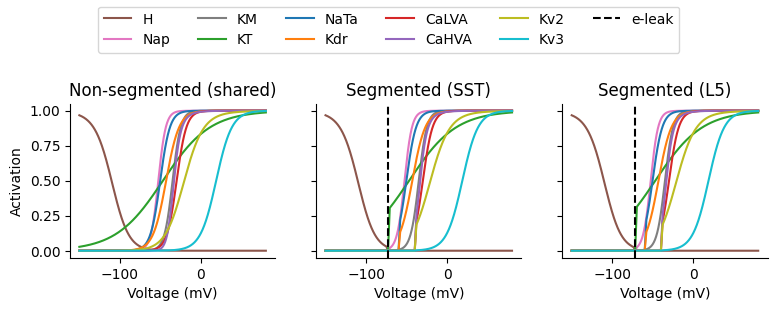

In [47]:
v = np.linspace(-150, 80, 1000)

fig, ax = plt.subplots(1, 3, figsize = (9, 2), sharey = True)

# Original
ca = ax[0]
for func, func_name in zip([H, Nap, Imv2, K_T, NaTa, Kd, CaLVA, CaHVA, Kv2like, Kv31], ["H", "Nap", "KM", "KT", "NaTa", "Kdr", "CaLVA", "CaHVA", "Kv2", "Kv3"]):
    ca.plot(v, func(v), label = func_name, color = color_map[func_name])
ca.set_ylabel("Activation")
ca.set_title("Non-segmented (shared)")

# SST
ca = ax[1]

segregator = ACTSegregator()
segregated_passive = segregator.segregate(v, [H(v)], cutoff_v = -72.9)
segregated_lto = segregator.segregate(v = v, activation_curves = [Nap(v), Imv2(v), K_T(v)], cutoff_v = -72.9)
segregated_spiking = segregator.segregate(v = v, activation_curves = [NaTa(v), Kd(v)], cutoff_v = -60)
segregated_bursting = segregator.segregate(v = v, activation_curves = [CaLVA(v), CaHVA(v), Kv2like(v), Kv31(v)], cutoff_v = -40)

for ac, ac_name in zip(segregated_passive, ["H"]):
    ca.plot(v, ac, label = ac_name, color = color_map[ac_name])

for ac, ac_name in zip(segregated_lto, ["Nap", "KM", "KT"]):
    ca.plot(v, ac, label = ac_name, color = color_map[ac_name])    

for ac, ac_name in zip(segregated_spiking, ["NaTa", "Kdr"]):
    ca.plot(v, ac, label = ac_name, color = color_map[ac_name])

for ac, ac_name in zip(segregated_bursting, ["CaLVA", "CaHVA", "Kv2", "Kv3"]):
    ca.plot(v, ac, label = ac_name, color = color_map[ac_name])

ca.axvline(-72.9, color = 'black', ls = '--', label = "e-leak")
ca.set_title("Segmented (SST)")

# L5
ca = ax[2]

segregator = ACTSegregator()
segregated_passive = segregator.segregate(v, [H(v)], cutoff_v = -71.7)
segregated_lto = segregator.segregate(v = v, activation_curves = [Nap(v), Imv2(v), K_T(v)], cutoff_v = -71.7)
segregated_spiking = segregator.segregate(v = v, activation_curves = [NaTa(v), Kd(v)], cutoff_v = -60)
segregated_bursting = segregator.segregate(v = v, activation_curves = [CaLVA(v), CaHVA(v), Kv2like(v), Kv31(v)], cutoff_v = -40)

for ac, ac_name in zip(segregated_passive, ["H"]):
    ca.plot(v, ac, label = ac_name, color = color_map[ac_name])

for ac, ac_name in zip(segregated_lto, ["Nap", "KM", "KT"]):
    ca.plot(v, ac, label = ac_name, color = color_map[ac_name])    

for ac, ac_name in zip(segregated_spiking, ["NaTa", "Kdr"]):
    ca.plot(v, ac, label = ac_name, color = color_map[ac_name])

for ac, ac_name in zip(segregated_bursting, ["CaLVA", "CaHVA", "Kv2", "Kv3"]):
    ca.plot(v, ac, label = ac_name, color = color_map[ac_name])

ca.axvline(-71.7, color = 'black', ls = '--', label = "e-leak")
ca.set_title("Segmented (L5)")

for ca in ax.flatten():
    ca.spines[['right', 'top']].set_visible(False)
    ca.set_xlabel("Voltage (mV)")

fig.legend(ca.get_legend_handles_labels()[0], ["H", "Nap", "KM", "KT", "NaTa", "Kdr", "CaLVA", "CaHVA", "Kv2", "Kv3", "e-leak"], loc = "upper center", ncol = 6)
fig.suptitle(" ", y = 1.35)

In [48]:
fig.savefig("F4a.png", format = 'png', bbox_inches = "tight", dpi = 500)